**Relevant reading for this problem set**:
<a href="https://moderndive.com/8-confidence-intervals.html"
target="_blank">ModernDive Chapter 8: Bootstrapping and Confidence
Intervals</a>.

## Background

In this problem set we will use a small **sample** of data from the
[General Social Survey](http://gss.norc.org/). The survey is designed to
monitor changes in both social characteristics and attitudes. You will
work with a **sample** from one neighborhood. The full neighborhood of
**ALL individuals** is the population. For this problem set we do
**not** know the **true population parameters** for any of the
variables, because we do not have data on every person in the
neighborhood.

## Setup

First load the necessary packages

In [2]:
# Recall that loading the tidyverse "umbrella" package loads ggplot2, dplyr, and
# readr all at once. Feel free to load these packages any way you choose.
library('tidyverse')
library('moderndive')

Warning message:
“Your system is mis-configured: ‘/var/db/timezone/localtime’ is not a symlink”
Warning message:
“‘/var/db/timezone/localtime’ is not identical to any known timezone file”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Next load the data set, from where it is stored on the web:

In [3]:
gss_sample = read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vSypSoDCMH2N76Vo2dZRPkw2q3t1mbvAXlOtgPDIsHg4NclAQFmER-BdvXH9_lrT40UQCVdPXOi_NMJ/pub?gid=257689625&single=true&output=csv", col_types = cols())

gss_sample |> glimpse()

Rows: 100
Columns: 3
$ age     <dbl> 79, 23, 31, 53, 39, 59, 45, 84, 52, 60, 21, 25, 56, 68, 58, 42…
$ race    <chr> "White", "White", "POC", "White", "White", "White", "White", "…
$ tvhours <dbl> 1, 1, 4, 4, 1, 1, 2, 3, 4, 3, 0, 3, 1, 3, 4, 1, 1, 2, 1, 5, 2,…


Be sure to take a look at the data in the **viewer**. Each row in the
data set is a person that was surveyed (100 rows or cases in total). The
variables in the data set include each respondent’s `age`, `race`, and
number of hours of TV watched a day `tvhours`.

**Setting a seed:** We will take some random samples and build sampling
distributions in this lab. In order to make sure R takes the same random
sample every time you run your code, you can do what is called “setting
a seed”. Do this in any code chunk that you take a random sample!

You can set a seed like so. Any number will do. (You do not need to run
this right now…just showing you how)

In [4]:
set.seed(45)

# Confidence intervals from a bootstrap resample

### Step 1: Take 1000 bootstrap resamples

The following code tells R to take 1000 bootstrap resamples from the
`gss_sample` data. You can set the seed to whatever value you like!

In [5]:
set.seed(42)

boot_samp_1000 = gss_sample |> 
  rep_sample_n(size = 100, reps = 1000, replace = TRUE)

boot_samp_1000 |> head()

replicate,age,race,tvhours
<int>,<dbl>,<chr>,<dbl>
1,37,POC,2
1,27,POC,5
1,76,White,0
1,25,White,0
1,67,White,2
1,20,White,2


In [6]:
glimpse(boot_samp_1000)

Rows: 100,000
Columns: 4
Groups: replicate [1,000]
$ replicate <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ age       <dbl> 37, 27, 76, 25, 67, 20, 37, 79, 33, 49, 67, 41, 40, 61, 40, …
$ race      <chr> "POC", "POC", "White", "White", "White", "White", "POC", "Wh…
$ tvhours   <dbl> 2, 5, 0, 0, 2, 2, 2, 5, 1, 3, 2, 1, 2, 5, 3, 4, 4, 1, 2, 1, …


Note a few important details about the `rep_sample_n` function, and
bootstrap sampling in general:

-   `size = 100` tells R that each bootstrap resample we take has 100
    cases… the size of the original sample
-   `reps = 1000` tells R to take 1000 bootstrap resamples (each of size
    100).
-   The `replace = TRUE` argument tells R that in each bootstrap
    resample, we can include a row from `gss_sample` multiple times. So
    if for instance, respondent \# 12 is the first random resample taken
    here, respondent 12 is still available to be resampled **again** at
    random. Thus, some people may appear **multiple times** in our
    bootstrap resample, and some people from the original data set may
    not appear at all.
-   We save the results in a data frame `boot_samp_1000`.

Take a look at the `boot_samp_1000` data frame we just generated in
RStudio’s data viewer. Note that the `replicate` column labels each
bootstrap resample (the first 100 rows are labeled 1, the next 100 rows
are labeled 2, etc.)

## Question 1

How many rows does `boot_samp_1000` have? **Why?**

**Answer:**

There are 100,000 rows. This is the result of the sample size = 100 times the number of replicates = 1000.
Hence 100 x 1000 = 100,000 rows



### Step 2: Calculate the bootstrap statistic

Let’s say we want to use the bootstrap resample that we just generated
to calculate a confidence interval for the population mean $\mu_{tv}$ of
`tvhours`. To do so, we need to know the sample mean $\bar{x}$ of
`tvhours` **for each of the 1000 bootstrap resamples**. In this case,
the sample mean $\bar{x}$ of `tvhours` for **each bootstrap resample**
is our **BOOTSTRAP STATISTIC**. We can calculate that with two lines of
code, like so:

In [7]:
boot_distrib_tv = boot_samp_1000 |>
  group_by(replicate) |> 
  summarize(boot_stat = mean(tvhours))

boot_distrib_tv |> head()

replicate,boot_stat
<int>,<dbl>
1,2.72
2,3.45
3,2.96
4,2.80
5,3.16
6,2.77


In [8]:
glimpse(boot_distrib_tv)

Rows: 1,000
Columns: 2
$ replicate <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1…
$ boot_stat <dbl> 2.72, 3.45, 2.96, 2.80, 3.16, 2.77, 4.01, 2.87, 3.02, 3.18, …


Note that:

-   The `group_by()` argument tells R to take the sample mean of
    `tvhours` **separately** for each different `replicate` in the
    bootstrap resample.
-   We put the sample mean for each bootstrap resample in a column
    called `boot_stat`

> This is the bootstrap distribution for the mean of `tvhours`!

Take a look at the `boot_distrib_tv` we just created in RStudio’s data
viewer.

## Question 2

How many values of the bootstrap statistic `boot_stat` are there? Please
explain **why** there are this many values of the bootstrap statistic.

**Answer:**.


There are 1000 bootstrap statistics. 
The group_by function was used on the replicates. Therefore, the 1000 bootstrap statistics is the mean of the 100 samples per replicate (1000 replicates). 


### Visualizing the bootstrap distribution

Make a histogram of the `boot_stat` values from `boot_distrib_tv`.

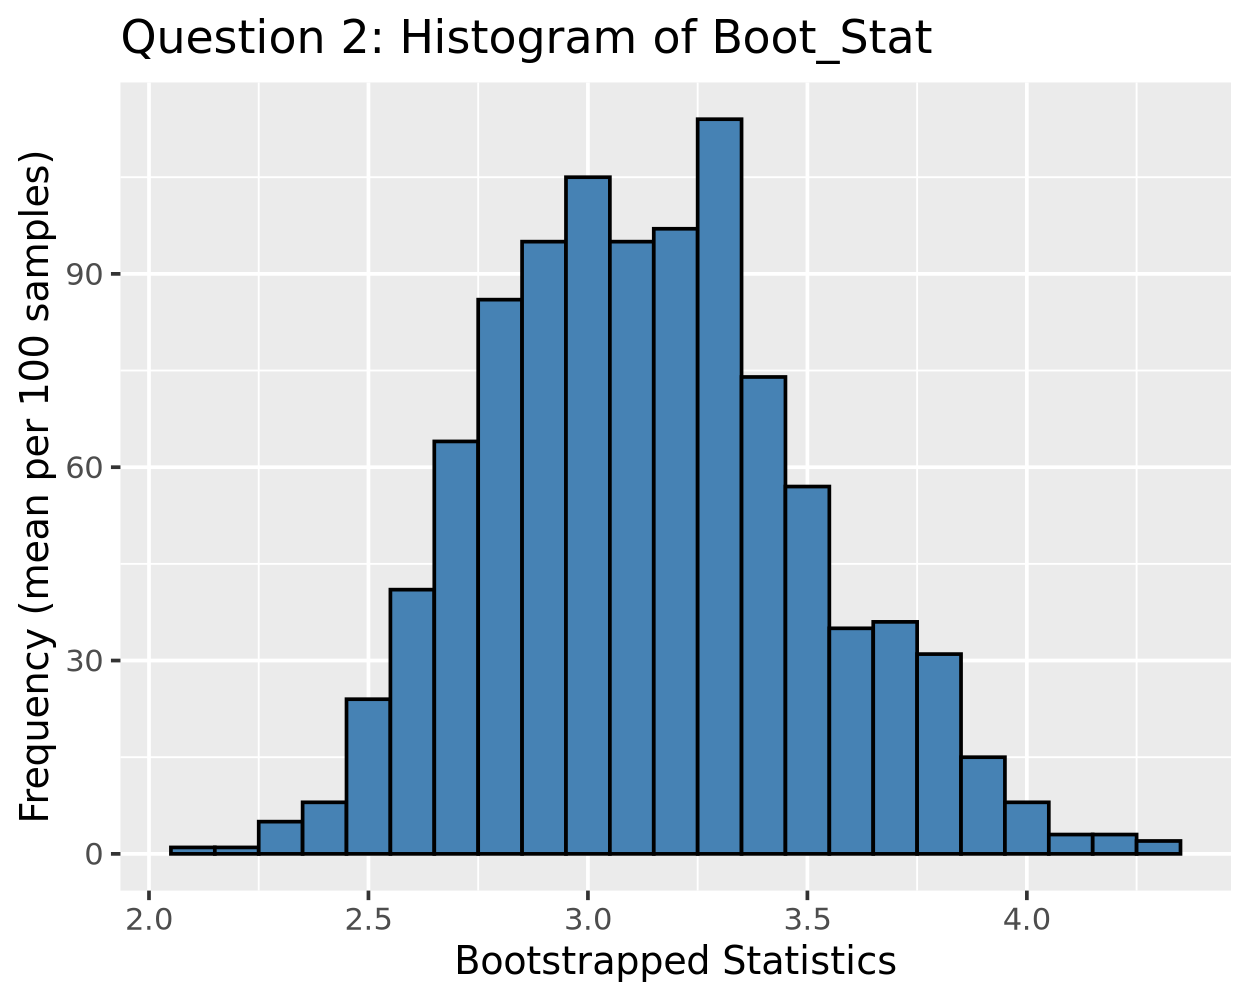

In [9]:
q2 = ggplot(boot_distrib_tv, aes(x= boot_stat)) +
        geom_histogram(binwidth = 0.1, fill = "steelblue", color = "black") +
        labs(title = "Question 2: Histogram of Boot_Stat",
             x = "Bootstrapped Statistics",
             y = "Frequency (mean per 100 samples)"
             )


q2

### Step 3: CI from a bootstrap resample

### a) CI using the 95% rule

We can now use the bootstrap distribution for the sample mean `tvhours`
$\bar{x}$ to calculate a 95% confidence interval for the population mean
`tvhours` $\mu_{tv}$, using the “95% rule for bell shaped
distributions”, which states that the middle 95% of values of a
bell/normal shaped distribution are between

$$\text{mean} \pm 1.96 \cdot SD$$

-   the mean here would be the mean of the bootstrap distribution
-   the SD here is the standard deviation of the bootstrap distribution,
    which recall has a special name: the **standard error**.

We can thus apply the 95% rule, like so:

In [10]:
boot_distrib_tv |>
  summarize(mean = mean(boot_stat), 
            se = sd(boot_stat), 
            lower_ci = mean - (1.96 * se), 
            upper_ci = mean + (1.96 * se))

mean,se,lower_ci,upper_ci
<dbl>,<dbl>,<dbl>,<dbl>
3.14418,0.3651603,2.428466,3.859894


### b) CI using percentile method

You can also calculate a 95% confidence interval using the percentile
method. The logic goes like this:

Since our bootstrap resample had 1000 values of `boot_stat`:

1.  950 of the `boot_stat` values fall **inside** this 95% confidence
    interval, i.e. 95%
2.  25 values fall **below** it. i.e. the lower 2.5%
3.  25 values fall **above** it. i.e. the higher 2.5%

totaling 100%. We can use **the quantiles** of the bootstrap
distribution to find these values like so:

In [12]:
prct_ci_tv = boot_distrib_tv |> 
  summarize(lower_ci = quantile(boot_stat, 0.025), 
            upper_ci = quantile(boot_stat, 0.975))

prct_ci_tv

lower_ci,upper_ci
<dbl>,<dbl>
2.51,3.89


This method

-   Asks R to identify the 0.025 quantile of the bootstrap sample means…
    this is the value **below** which **2.5% of the values of
    `boot_stat`** fall (or 25 cases in this example… 25/1000 = 0.025)
-   Asks R to identify the 0.975 quantile for the bootstrap sample
    means… this is the value **above** which the other **2.5% of the
    values of `boot_stat`** fall (or 25 cases in this example 975/1000 =
    0.975)
-   The middle 95% of the values fall between these two quantiles

Based on these results, we are 95% confident that the **true mean hours
of TV watched $\mu_{tv}$ in the population** is between the upper and
lower CI we just calculated.

### Visualizing the Confidence interval

Display the bootstrap distribution and the 95% confidence intervals we just
calculated below. 

1. Make a histogram of the `boot_stat` values from `boot_distrib_tv`.
2. Add a green line for the lower bound of the 95% CI, and,
3. a blue line fir the upper bound.
 
950 of the 1000 bootstrap resamples had a mean for `tvhours` that fell **between**
the green and blue lines…25 of the samples had a mean above the blue
line, and 25 of the samples had a mean below the green line.

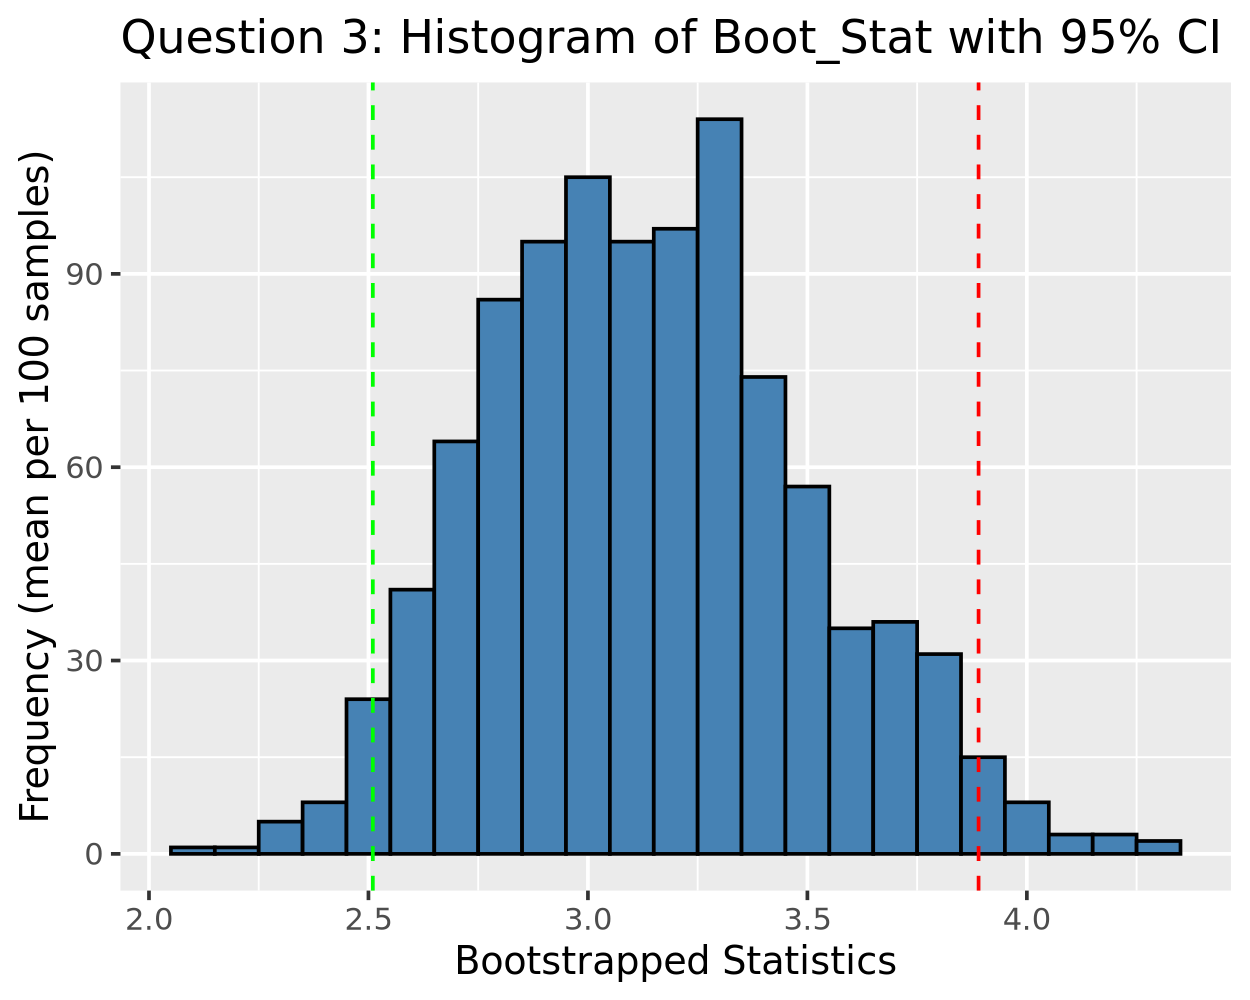

In [13]:
# Extract the values from the prct_ci_tv calculations
lower <- prct_ci_tv$lower_ci
upper <- prct_ci_tv$upper_ci

q3 = ggplot(boot_distrib_tv, aes(x= boot_stat)) +
        geom_histogram(binwidth = 0.1, fill = "steelblue", color = "black") +
        geom_vline(xintercept = lower, linetype = "dashed", color = "green") +
        geom_vline(xintercept = upper, linetype = "dashed", color = "red") +
        labs(title = "Question 3: Histogram of Boot_Stat with 95% CI",
             x = "Bootstrapped Statistics",
             y = "Frequency (mean per 100 samples)"
             )



q3



## Question 3

**If** we calculated a **90% confidence interval** for the mean of
`tvhours` using this same bootstrap resample and the percentile method,
roughly how many of the 1000 values of `tv_mean` would fall between the
green and blue lines?

**Answer:**

There would be approximately 900 of 1000 that fall within the 90% CI. 

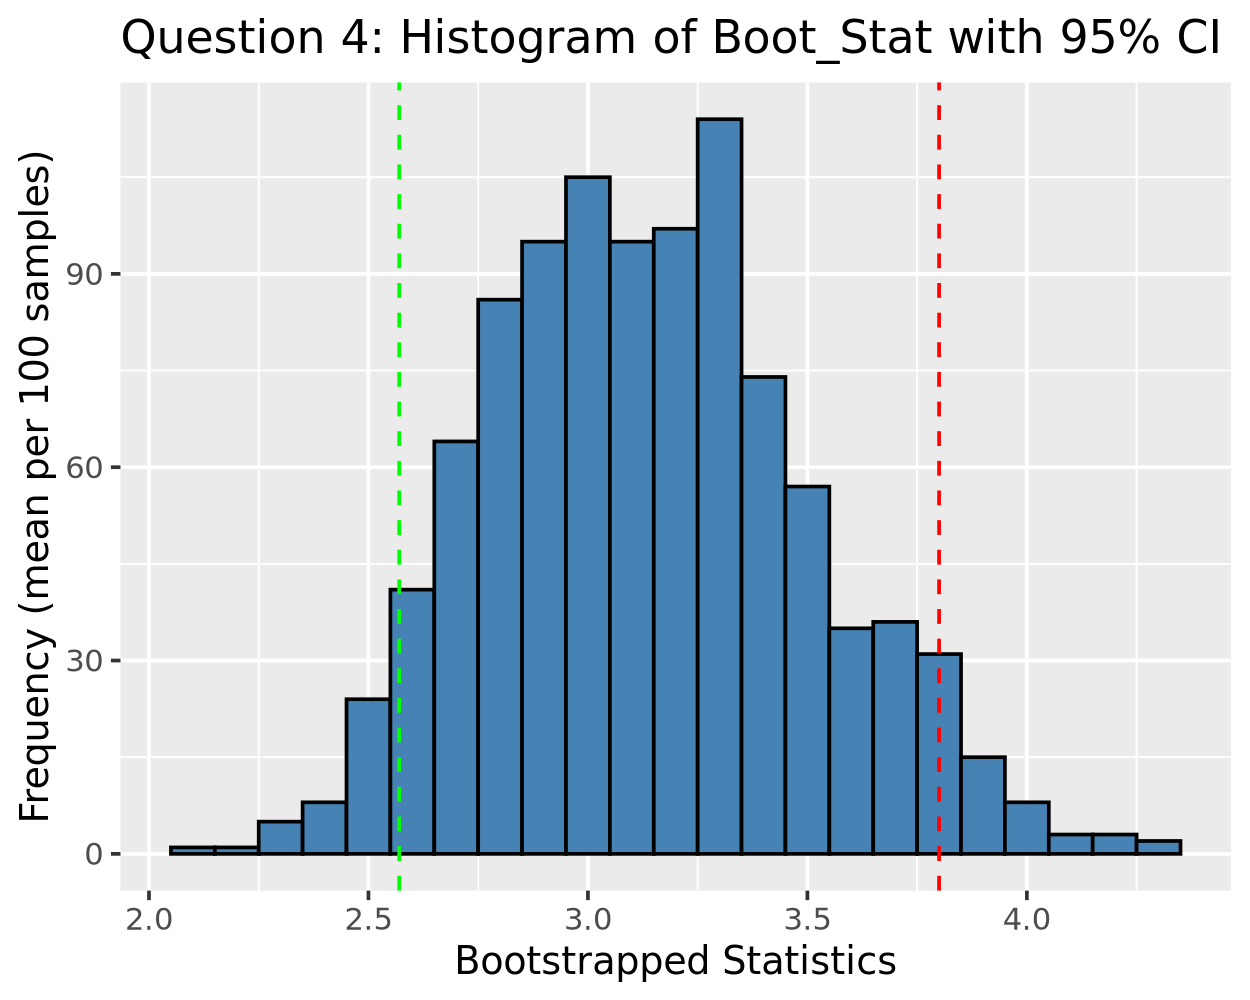

In [14]:
prct_ci_tv_90 = boot_distrib_tv |> 
  summarize(lower_ci = quantile(boot_stat, 0.05), 
            upper_ci = quantile(boot_stat, 0.95))

lower <- prct_ci_tv_90$lower_ci
upper <- prct_ci_tv_90$upper_ci

q3 = ggplot(boot_distrib_tv, aes(x= boot_stat)) +
        geom_histogram(binwidth = 0.1, fill = "steelblue", color = "black") +
        geom_vline(xintercept = lower, linetype = "dashed", color = "green") +
        geom_vline(xintercept = upper, linetype = "dashed", color = "red") +
        labs(title = "Question 4: Histogram of Boot_Stat with 95% CI",
             x = "Bootstrapped Statistics",
             y = "Frequency (mean per 100 samples)"
             )



q3



## Question 4

Use the bootstrap resampling distribution for `tvhours` generated above
(`boot_distrib_tv`) and the **percentile** method to calculate a 99%
confidence interval for the mean `tvhours`.

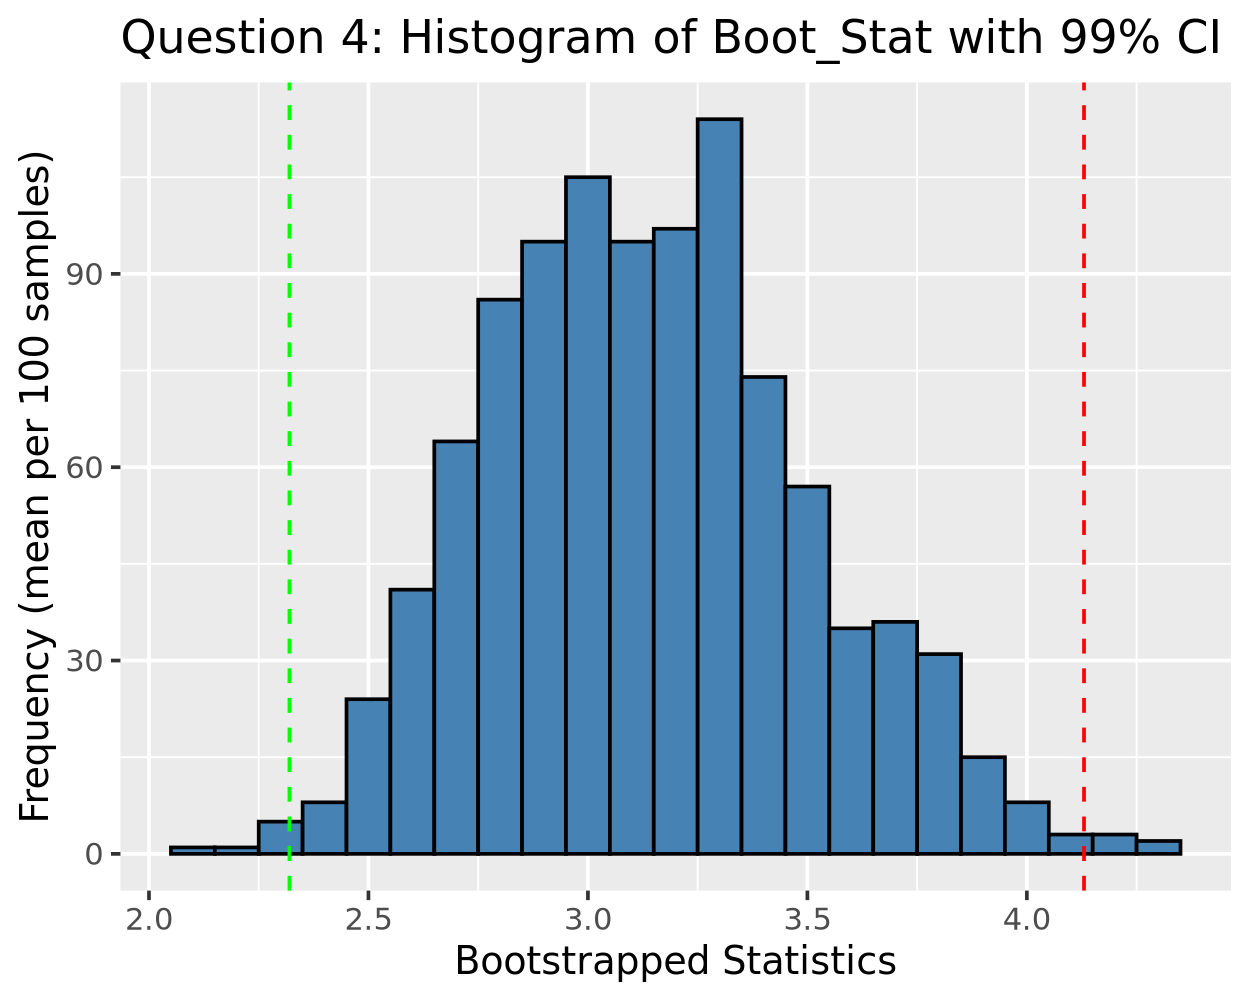

In [15]:
prct_ci_tv_99 = boot_distrib_tv |> 
  summarize(lower_ci = quantile(boot_stat, 0.005), 
            upper_ci = quantile(boot_stat, 0.995))

lower <- prct_ci_tv_99$lower_ci
upper <- prct_ci_tv_99$upper_ci

q4 = ggplot(boot_distrib_tv, aes(x= boot_stat)) +
        geom_histogram(binwidth = 0.1, fill = "steelblue", color = "black") +
        geom_vline(xintercept = lower, linetype = "dashed", color = "green") +
        geom_vline(xintercept = upper, linetype = "dashed", color = "red") +
        labs(title = "Question 4: Histogram of Boot_Stat with 99% CI",
             x = "Bootstrapped Statistics",
             y = "Frequency (mean per 100 samples)"
             )



q4



## Question 5

Which confidence interval is **WIDER**: the 95% confidence interval or
the 99% confidence interval for the population mean `tvhours`
$\mu_{tv}$? Why is this the case? Answer in terms of the trade-off
between confidence level and confidence interval width.

**Answer:**

The 99% confidence interval is wider than the 95% confidence interval. The confidence interval relates to the percent of the population that fall within the upper and lower CI limits. Therefore, 99% CI incorporates 99% of the population while 95% only incorporates 95% of the population. 



## Question 6.a)

Use the bootstrap resample we generated above (`boot_samp_1000`), to
generate a **bootstrap distribution** for the sample mean respondent
`age` $\bar{x}$ instead of `tvhours`. Please be sure to **name it
something different** than the bootstrap distribution for the sample
mean of `tvhours`

In [17]:
boot_distrib_age = boot_samp_1000 |>
  group_by(replicate) |> 
  summarize(boot_stat = mean(age))

boot_distrib_age |> head()


replicate,boot_stat
<int>,<dbl>
1,47.12
2,49.01
3,45.54
4,47.06
5,46.11
6,46.85


## Question 6.b)

Calculate a 95% confidence interval for the population mean respondent
`age` $\mu_{age}$ using the **95% rule** method.

In [21]:
boot_distrib_age |>
  summarize(mean = mean(boot_stat), 
            se = sd(boot_stat), 
            lower_ci = mean - (1.96 * se), 
            upper_ci = mean + (1.96 * se))


mean,se,lower_ci,upper_ci
<dbl>,<dbl>,<dbl>,<dbl>
47.60143,1.673659,44.32106,50.8818


## Question 6.c)

Calculate a 95% confidence interval for the population mean respondent
`age` $\mu_{age}$ using the **percentile** method.

In [25]:
prct_ci_age_95 = boot_distrib_age |> 
  summarize(lower_ci = quantile(boot_stat, 0.005), 
            upper_ci = quantile(boot_stat, 0.995))

lower <- prct_ci_age_95$lower_ci
upper <- prct_ci_age_95$upper_ci

prct_ci_age_95




lower_ci,upper_ci
<dbl>,<dbl>
43.4498,52.0801


## Question 6.d)

How do the 95% confidence intervals you calculated in 6b and 6c compare?
i.e. are the 95% CI values similar or are they pretty different?

**Answer:**

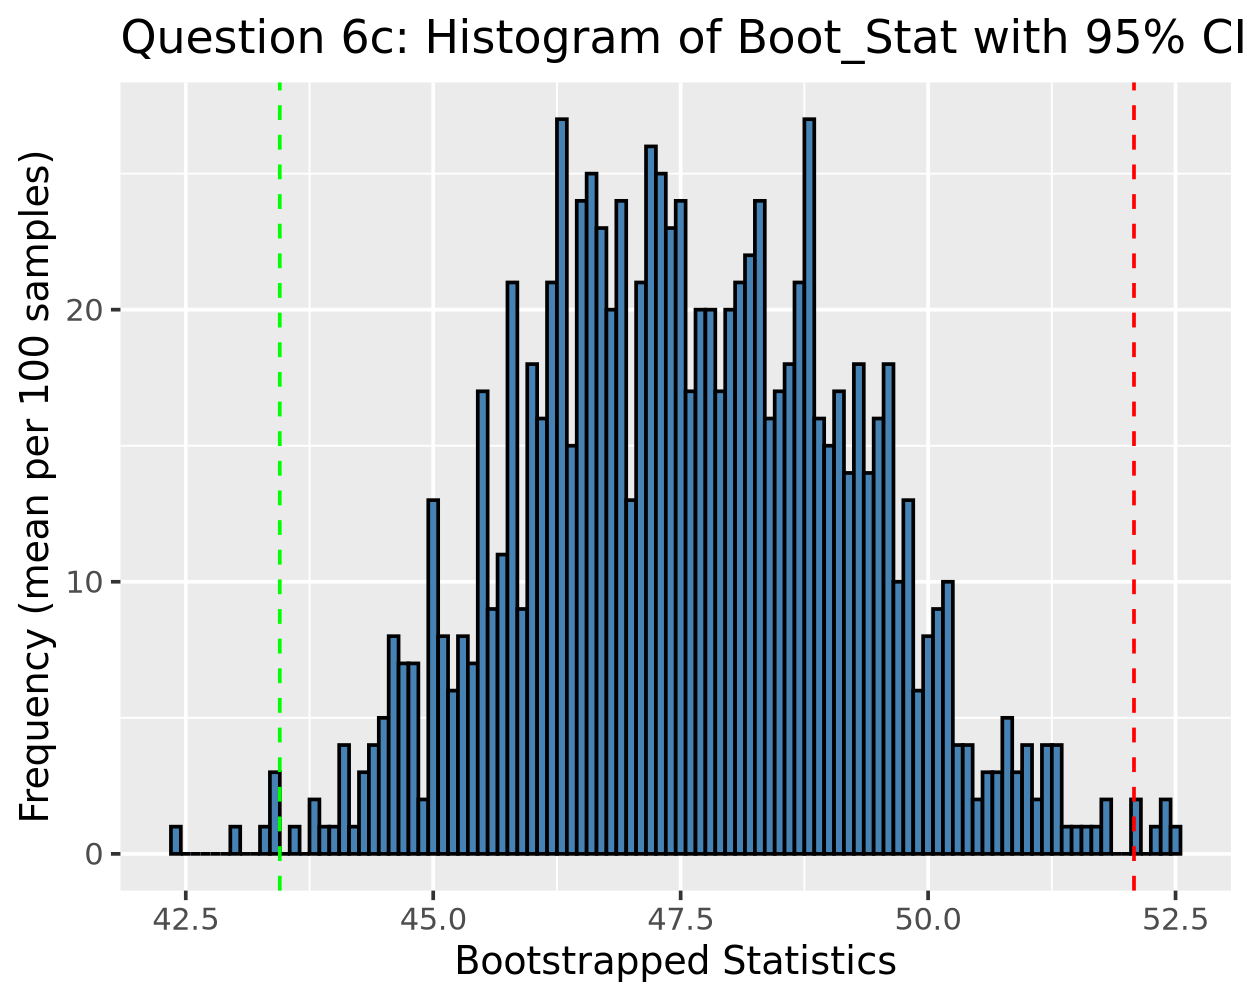

## Question 7

Use the **bootstrap resampling distribution** for the sample mean
respondent `age` and the percentile method to calculate an 80%
confidence interval for the population mean respondent age $\mu_{age}$.

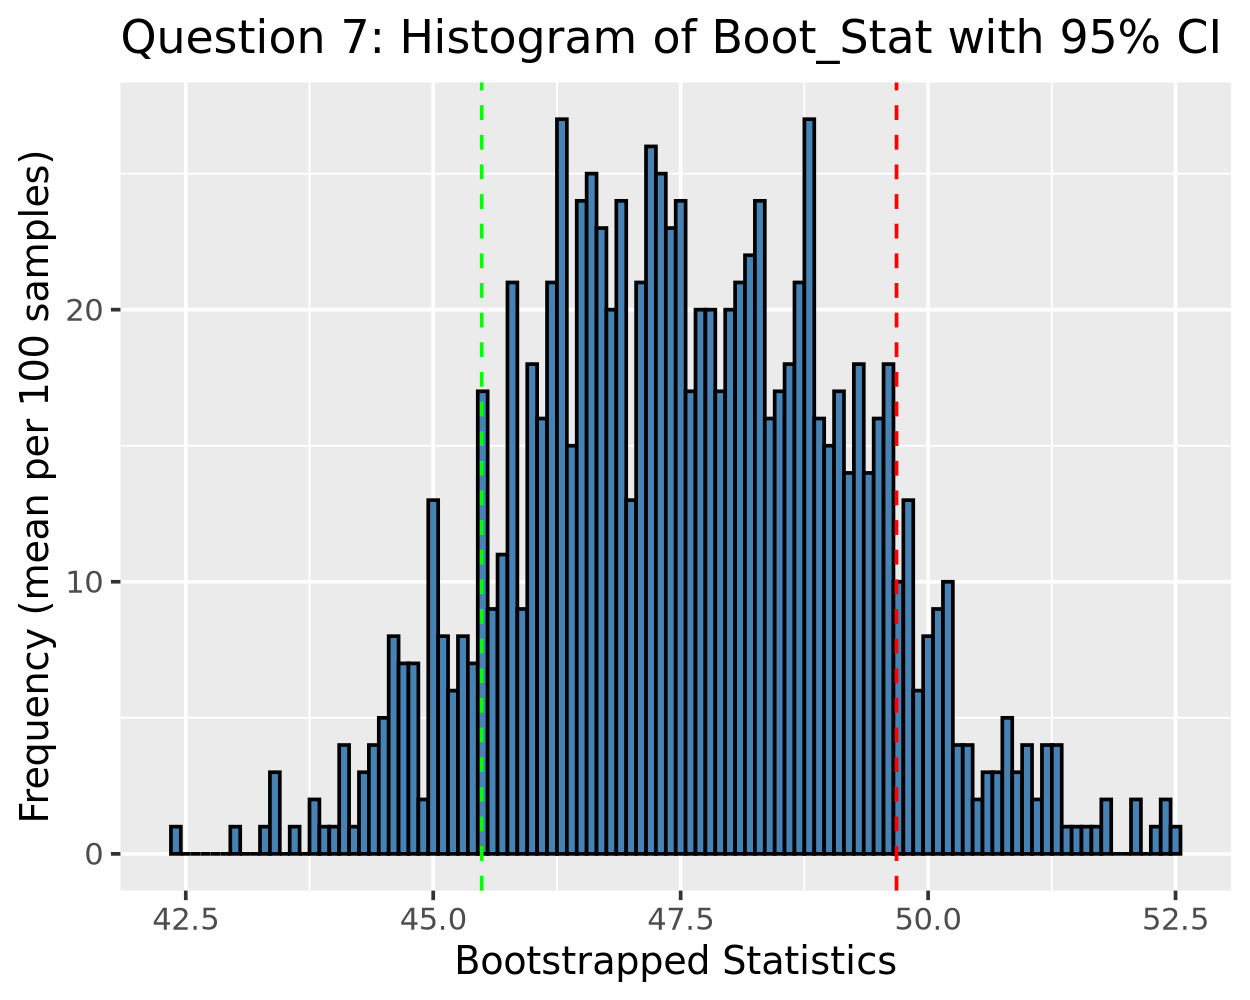

In [27]:
prct_ci_age_80 = boot_distrib_age |> 
  summarize(lower_ci = quantile(boot_stat, 0.1), 
            upper_ci = quantile(boot_stat, 0.9))

lower <- prct_ci_age_80$lower_ci
upper <- prct_ci_age_80$upper_ci




q7 = ggplot(boot_distrib_age, aes(x= boot_stat)) +
        geom_histogram(binwidth = 0.1, fill = "steelblue", color = "black") +
        geom_vline(xintercept = lower, linetype = "dashed", color = "green") +
        geom_vline(xintercept = upper, linetype = "dashed", color = "red") +
        labs(title = "Question 7: Histogram of Boot_Stat with 95% CI",
             x = "Bootstrapped Statistics",
             y = "Frequency (mean per 100 samples)"
             )



q7


# Bootstrap sampling distribution & confidence intervals with categorical variables

The procedure for generating a bootstrap sampling distribution is VERY
similar for categorical data. As an example we will generate a bootstrap
sampling distribution for the proportion of respondents that identified
as a Person of Color.

### Step 1: Take 1000 bootstrap resamples

We already did this above! We can use the same `boot_samp_1000` as
before.

### Step 2: Calculate the bootstrap statistic $\hat{p}$

In [28]:
boot_distrib_POC = boot_samp_1000 |> 
  group_by(replicate) |> 
  summarize(n = n(), 
            POC_count = sum(race == "POC"), 
            boot_stat = POC_count/n)

boot_distrib_POC |> head()

replicate,n,POC_count,boot_stat
<int>,<int>,<int>,<dbl>
1,100,26,0.26
2,100,24,0.24
3,100,25,0.25
4,100,16,0.16
5,100,28,0.28
6,100,22,0.22


Note that with a categorical variable, the code differs in two important
respects now:

-   the population parameter that we don’t know, but are inferring about
    via sampling, is now the population proportion $p$ that identify as
    a POC.
-   the sample statistic AKA point estimate that we calculate with the
    summarize command is now the **sample proportion** $\widehat{p}$
    rather than a sample mean $\bar{x}$
-   To get our proportion $\widehat{p}$ of **ONE** of the race
    categories (POC), we need to **first** calculate the total sample
    size for each replicate and the count of how many cases are
    `race == "POC"` in each replicate.

### Step 3: Generate the 95% Confidence Interval

### a) CI using the 95% rule

The following will calculate the 95% confidence interval for the
proportion of people that identified as `POC` using the 95% rule.

In [29]:
boot_distrib_POC |> 
  summarize(mean = mean(boot_stat), 
            se = sd(boot_stat), 
            lower_ci = mean - (1.96 * se), 
            upper_ci = mean + (1.96 * se))

mean,se,lower_ci,upper_ci
<dbl>,<dbl>,<dbl>,<dbl>
0.24053,0.04213543,0.1579446,0.3231154


### b) CI with the percentile method

The following will calculate the 95% confidence interval for the
proportion of people that identified as “POC” using the percentile
method.

In [30]:
boot_distrib_POC |> 
  summarize(lower_ci = quantile(boot_stat, 0.025), 
            upper_ci = quantile(boot_stat, 0.975))

lower_ci,upper_ci
<dbl>,<dbl>
0.16,0.33


## Question 8

Calculate a 95% CI for the **population proportion** of respondents $p$
that identified as **White** using EITHER the percentile or 95% rule
method. Note that you will first need to generate the bootstrap
distribution for the proportion of respondents that identified as
`White`.

In [31]:
boot_distrib_white = boot_samp_1000 |> 
  group_by(replicate) |> 
  summarize(n = n(), 
            white_count = sum(race == "White"), 
            boot_stat = white_count/n)

boot_distrib_white |> head()



replicate,n,white_count,boot_stat
<int>,<int>,<int>,<dbl>
1,100,74,0.74
2,100,76,0.76
3,100,75,0.75
4,100,84,0.84
5,100,72,0.72
6,100,78,0.78


In [32]:
boot_distrib_white |> 
  summarize(mean = mean(boot_stat), 
            se = sd(boot_stat), 
            lower_ci = mean - (1.96 * se), 
            upper_ci = mean + (1.96 * se))

mean,se,lower_ci,upper_ci
<dbl>,<dbl>,<dbl>,<dbl>
0.75947,0.04213543,0.6768846,0.8420554


In [33]:
boot_distrib_white |> 
  summarize(lower_ci = quantile(boot_stat, 0.025), 
            upper_ci = quantile(boot_stat, 0.975))

lower_ci,upper_ci
<dbl>,<dbl>
0.67,0.84


# Confidence intervals based on the theoretical normal distribution

As described in [moderndive chapter
8.7.2](https://moderndive-bert.netlify.com/8-confidence-intervals.html#theory-ci),
not only can we generate confidence intervals using a
computer/resampling as we’ve been doing until now, in many cases there
also exists a mathematical formula! This however necessitates a little
mathematical/probability theory; a topic we leave to a more advanced
statistics class.

To generate a 95% confidence interval based on the theoretical normal
distribution, we can use the following formula:

$$ \text{point estimate} \pm 1.96 \cdot \widehat{SE}$$

So, for instance if we wanted to calculate the 95% confidence interval
for the population mean of `tvhours` $\mu_{tv}$ that respondents watched
based on our sample:

-   the **point estimate** AKA **sample statistic** in this case would
    be the sample mean number of `tvhours` from the sample: $\bar{x}$
-   We would estimate the standard error using the formula

$$\widehat{SE} \approx \frac{s}{\sqrt{n}}$$

where $s$ is the **sample standard deviation**, which is a point
estimate of the **population standard deviation** $\sigma$.

Thus a 95% CI would be

$$
\bar{x} \pm 1.96 \cdot \widehat{SE} =  \bar{x} \pm 1.96 \cdot \frac{s}{\sqrt{n}}
$$

We can make these calculations in R like so:

In [34]:
gss_sample |> 
  summarize(x_bar = mean(tvhours), 
            sd = sd(tvhours), 
            n = n(), 
            se = sd/sqrt(n), 
            lower_ci = x_bar - 1.96 * se, 
            upper_ci = x_bar + 1.96 * se)

x_bar,sd,n,se,lower_ci,upper_ci
<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
3.14,3.592979,100,0.3592979,2.435776,3.844224


## Question 9

Write down the three 95% confidence intervals for the population mean of
`tvhours` $\mu_{tv}$ you’ve computed in this problem set. Do this by
replacing X, Y, A, B, P, and Q with the appropriate values you’ve
computed.

When you are done, make sure all the `|` in the table still line up so
your results print out in a table!

| CI construction method          | lower value | upper value |
|---------------------------------|-------------|-------------|
| Using boostrap: 95% rule        | 2.43        | 3.86        |
| Using boostrap: percentile rule | 2.51        | 3.89        |
| Using mathematical formula      | 2.43        | 3.84        |

## Question 10

**In your opinion**, would you say these three confidence intervals are
similar?

**Answer:**

In my opinion, the method produced similar datasets. This can be expected since the data is normally distributed about the mean. The three methods have their advantages. The 95% rule is a quick method for quick approximations. The mathematical formula method offers precision and consistency if certain assumptions are met (e.g. sufficietnly large sample size and normal or approximately normally distributed). The percentile rule can be applied to either normal or non-normal distributions.  

